<a href="https://colab.research.google.com/github/Preciousosas/Stage-E/blob/main/Individual_Household_Electric_Power_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = '/content/drive/MyDrive/Hamoye/household_power_consumption.txt'

# Import and mege Date and time Column as DateTime
df = pd.read_csv(url, sep=';', na_values=['nan','?'],parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True)

A seperator type of ';' was use instead of the usual ' ' separator. The na_values is to make the nan and ? both null values.

In [ ]:
df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
# check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [ ]:
# check for missing values
df.isnull().sum()

datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Identify and extract rows with any null values
df[df.isnull().any(axis=1)]

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19725,2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41832,2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1990185,2010-09-28 19:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990186,2010-09-28 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990187,2010-09-28 19:11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990188,2010-09-28 19:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's tackle the missing Values by using a forward fill

In [ ]:
# Let's perform forward fill
df.fillna(method= 'ffill',inplace = True)

In [ ]:
df.isnull().sum()

datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
# Resample the data to hourly frequency, summing over each hour
df_hourly = df.resample('H', on='datetime').sum()

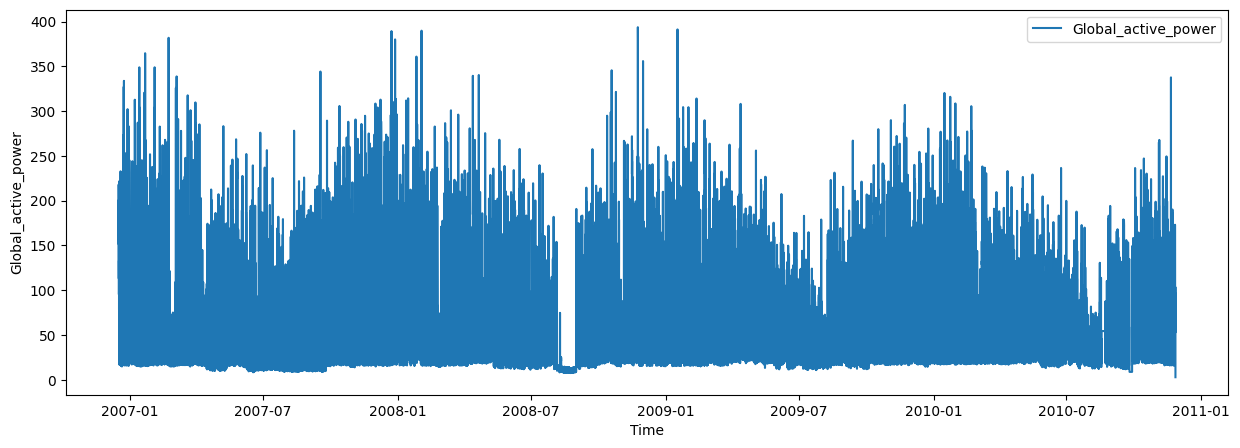

In [ ]:
# Make a plot of Global_active_power using matplotlib
plt.figure(figsize=(15,5))
plt.plot(df_hourly.index, df_hourly['Global_active_power'], label='Global_active_power')
plt.xlabel('Time')
plt.ylabel('Global_active_power')
plt.legend()

In [ ]:
#  Pearson correlation coefficient between the global_active_power and voltage To 3 decimal places
corr_gl = df['Global_active_power'].corr(df['Voltage'])
corr_gl.round(3)

-0.396

In [ ]:
# Pearson correlation coefficient between the Voltage and global_intensity To 2 decimal places
corr_vo = df['Voltage'].corr(df['Global_intensity'])
corr_vo.round(2)

-0.41

In [ ]:
# Resample the data to day frequency, summing over each day
df_daily = df.resample('D', on ='datetime').sum()

In [ ]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB


In [ ]:
# split the dataframe
split = len(df_daily) - 300

# Split the DataFrame into training and test sets
df_train = df_daily[:split]
df_test = df_daily[split:]

In [ ]:
# Reset the index
df_test.reset_index(inplace=True)
df_train.reset_index(inplace=True)

# **Building Prophet model**

In [ ]:
from prophet import Prophet

In [ ]:
# Set the dataframe for the prophet model
data_test = df_test[['datetime','Global_active_power']]
data_train = df_train[['datetime','Global_active_power']]

# rename the columns name to suit the prophet model
data_test.rename(columns={'datetime':'ds','Global_active_power':'y'},inplace=True)
data_train.rename(columns={'datetime':'ds','Global_active_power':'y'},inplace=True)

In [ ]:
data_train.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [ ]:
# Initialize Prophet model
model = Prophet()

# Fit the model
model.fit(data_train)

# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=300,freq='D')

# Make predictions
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ovnhhc0/xizwryfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ovnhhc0/t_yshbqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39541', 'data', 'file=/tmp/tmp1ovnhhc0/xizwryfx.json', 'init=/tmp/tmp1ovnhhc0/t_yshbqb.json', 'output', 'file=/tmp/tmp1ovnhhc0/prophet_modelmyf20ke8/prophet_model-20240620112549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Check the forecast data
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1641.801341,1800.718379,2884.003118,1641.801341,1641.801341,709.612333,709.612333,709.612333,233.435831,233.435831,233.435831,476.176502,476.176502,476.176502,0.0,0.0,0.0,2351.413675
1,2006-12-17,1641.639985,1800.182033,2886.058434,1641.639985,1641.639985,701.350507,701.350507,701.350507,210.643678,210.643678,210.643678,490.706829,490.706829,490.706829,0.0,0.0,0.0,2342.990492
2,2006-12-18,1641.478629,1425.478952,2567.634078,1641.478629,1641.478629,343.478339,343.478339,343.478339,-162.600237,-162.600237,-162.600237,506.078576,506.078576,506.078576,0.0,0.0,0.0,1984.956968
3,2006-12-19,1641.317274,1565.287120,2733.048126,1641.317274,1641.317274,502.421963,502.421963,502.421963,-19.427511,-19.427511,-19.427511,521.849474,521.849474,521.849474,0.0,0.0,0.0,2143.739237
4,2006-12-20,1641.155918,1573.881034,2714.198029,1641.155918,1641.155918,523.838386,523.838386,523.838386,-13.728763,-13.728763,-13.728763,537.567149,537.567149,537.567149,0.0,0.0,0.0,2164.994303


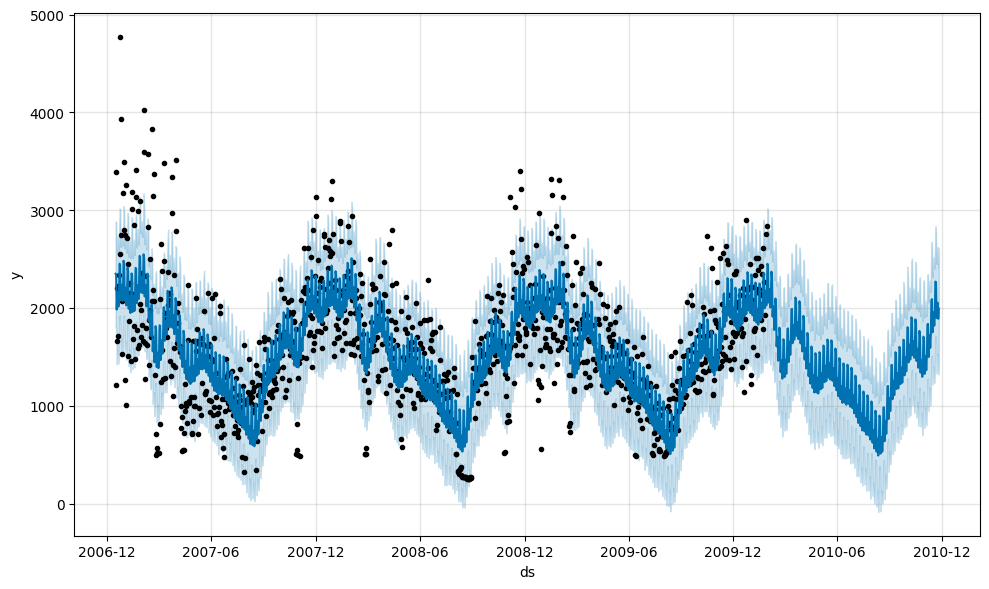

In [ ]:
# plot the forecast
model.plot(forecast)
plt.show()

In [ ]:
test_forecast = forecast[split:]

test_forecast.shape

(300, 19)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(data_test['y'], test_forecast['yhat']) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 27.20%


In [ ]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(data_test['y'], test_forecast['yhat']))
print(f"RMSE: {rmse:.2f}")

RMSE: 401.61


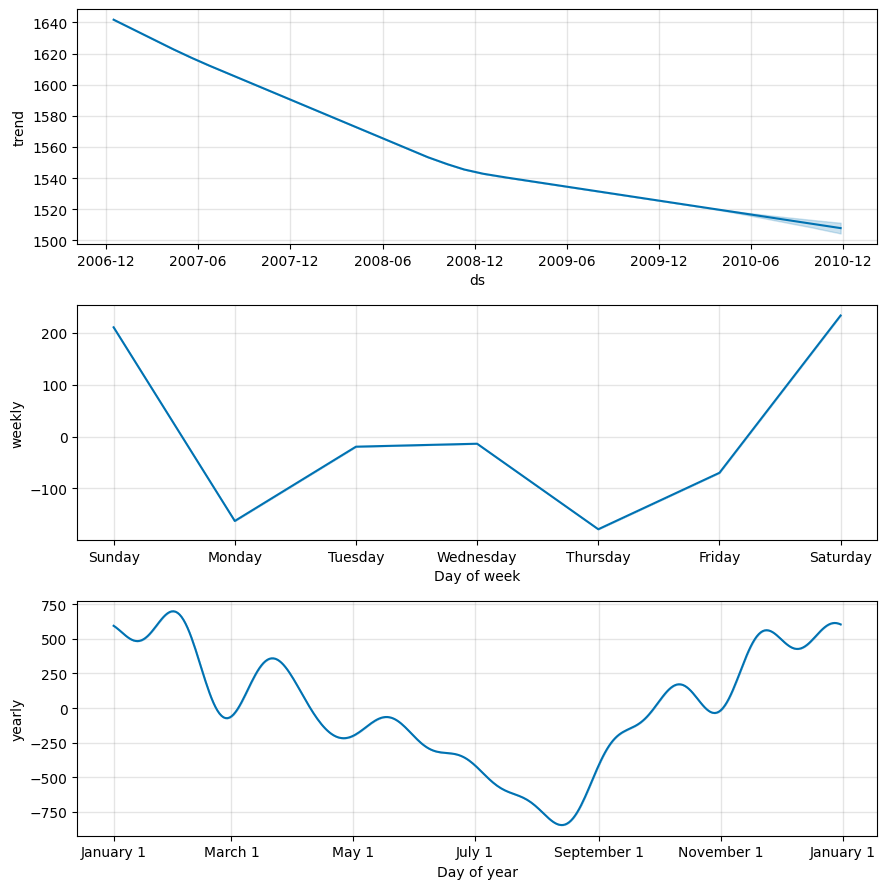

In [ ]:
# Plot the forecast components
fig = model.plot_components(forecast)

**Building Prophet model with Regressors**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   datetime               1142 non-null   datetime64[ns]
 1   Global_active_power    1142 non-null   float64       
 2   Global_reactive_power  1142 non-null   float64       
 3   Voltage                1142 non-null   float64       
 4   Global_intensity       1142 non-null   float64       
 5   Sub_metering_1         1142 non-null   float64       
 6   Sub_metering_2         1142 non-null   float64       
 7   Sub_metering_3         1142 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 71.5 KB


In [ ]:
# rename the columns name to suit the prophet model
df_train.rename(columns={'datetime':'ds','Global_active_power':'y','Global_reactive_power':'add1','Voltage':'add2','Global_intensity':'add3',
                         'Sub_metering_1':'add4','Sub_metering_2':'add5','Sub_metering_3':'add6'},inplace=True)

In [ ]:
df_train.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [ ]:
# Initialize the Prophet model
model = Prophet()

# Add regressors
model.add_regressor('add1')
model.add_regressor('add2')
model.add_regressor('add3')
model.add_regressor('add4')
model.add_regressor('add5')
model.add_regressor('add6')

# Fit the model
model.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ovnhhc0/zsid1_kg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1ovnhhc0/5fx4w60i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23979', 'data', 'file=/tmp/tmp1ovnhhc0/zsid1_kg.json', 'init=/tmp/tmp1ovnhhc0/5fx4w60i.json', 'output', 'file=/tmp/tmp1ovnhhc0/prophet_modeljmc9u8zo/prophet_model-20240620112552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:25:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create a DataFrame for future dates, including regressors
future_reg = model.make_future_dataframe(periods=300,freq='D')
future_reg['add1'] = 1
future_reg['add2'] = 2
future_reg['add3'] = 3
future_reg['add4'] = 4
future_reg['add5'] = 5
future_reg['add6'] = 6

# Make prediction
forecst_reg = model.predict(future_reg)

#plot forecast
model.plot(forecst_reg)
plt.show()

In [ ]:
test_forecst_reg = forecst_reg[split:]

test_forecst_reg.shape

In [ ]:
mape = mean_absolute_percentage_error(data_test['y'], test_forecst_reg['yhat']) * 100
print(f"MAPE: {mape:.2f}%")

In [ ]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(data_test['y'], test_forecst_reg['yhat']))
print(f"RMSE: {rmse:.2f}")

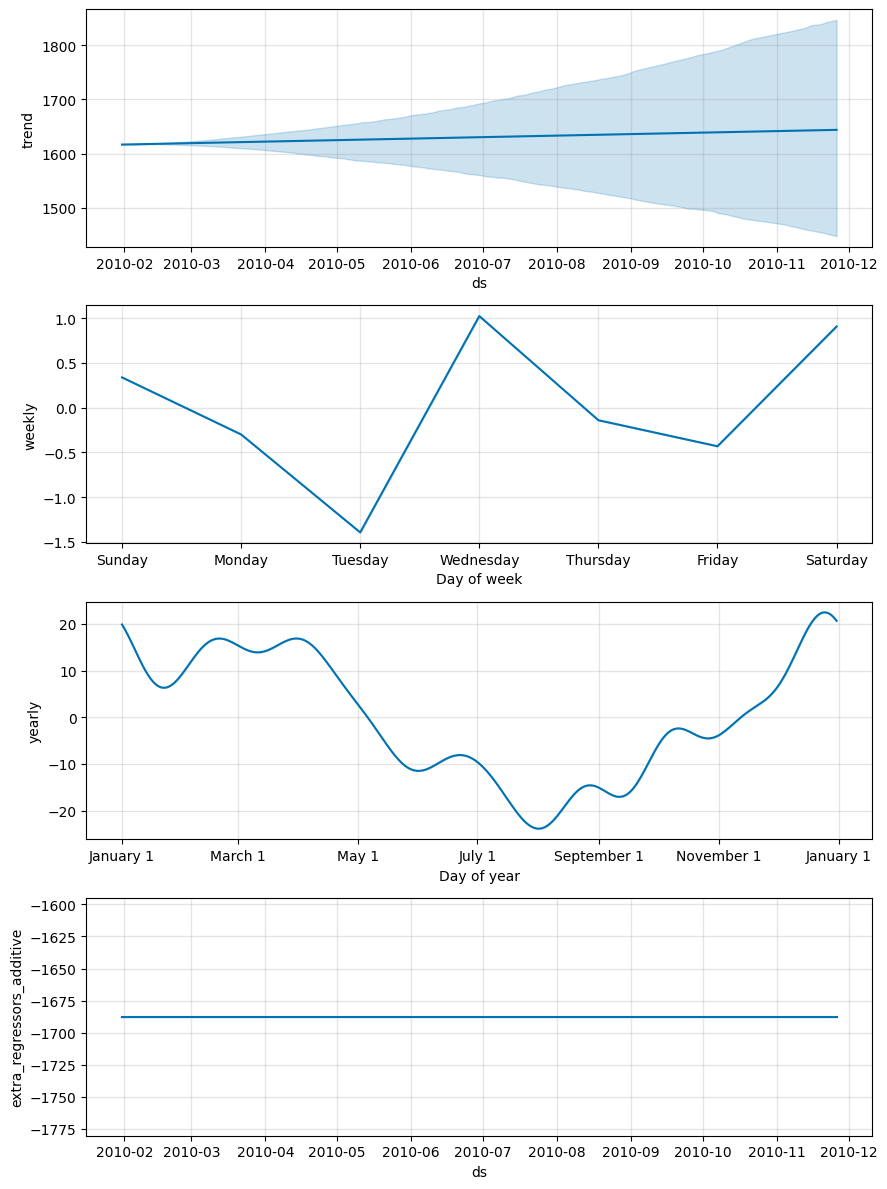

In [ ]:
# Plot the forecast components
fig = model.plot_components(test_forecst_reg)